In [1]:
from flair.data import Sentence

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
sentence = Sentence('George Washington went to Washington .')

In [4]:
sentence

Sentence: "George Washington went to Washington ." - 6 Tokens

In [5]:
sentence.get_token(4)

Token: 4 to

In [6]:
sentence[3]

Token: 4 to

In [7]:
from flair.models import SequenceTagger

In [8]:
tagger = SequenceTagger.load('ner')

2019-03-02 16:56:20,675 loading file /Users/umemoto/.flair/models/en-ner-conll03-v0.4.pt


In [10]:
tagger.predict(sentence)

[Sentence: "George Washington went to Washington ." - 6 Tokens]

In [11]:
sentence.to_tagged_string()

'George <B-PER> Washington <E-PER> went to Washington <S-LOC> .'

In [1]:
%pwd

'/Users/umemoto/work'

In [5]:
import os
from pathlib import Path

task = 'ja-wikinews-ner'
data_folder = Path(os.environ['HOME']) / '.flair/datasets' / task

In [12]:
import math

with open('IOB2Corpus/hironsan.txt') as f:
    lines = f.readlines()
    
stages = ['train', 'dev', 'test']
split_ratio = {'train': 0.8, 'dev': 0.1, 'test': 0.1}
N = lines.count('\n')
n_train = math.ceil(N * split_ratio['train'])
n_dev = math.ceil(N * (1.0 - split_ratio['test']))

data_folder.mkdir(parents=True, exist_ok=True)
fs = {s: open(data_folder / f'{s}.txt', 'w') for s in stages}
n = 0
for line in lines:
    cols = line.split('\t')
    if len(cols) == 9: cols.insert(-1, '*')
    if len(cols) == 10: cols.insert(-1, '*')
    if len(cols) == 1 or len(cols) == 11:
        s = 'train' if n < n_train else 'dev' if n < n_dev else 'test'
        fs[s].write('\t'.join(cols))
    else:
        raise Exception(f'invalid line with {len(cols)} columns: {line.strip()}')
    if len(cols) == 1: n += 1
for s in stages: fs[s].close()
print(N, n_train, n_dev - n_train, N - n_dev)

500 400 50 50


In [6]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, BertEmbeddings, CharacterEmbeddings

# define columns
columns = {0: 'text', 1: 'pos', 10: 'ner'}

# 1. get the corpus
corpus = NLPTaskDataFetcher.load_column_corpus(data_folder, columns)
print(corpus)

2019-03-02 19:59:09,588 Reading data from /Users/umemoto/.flair/datasets/ja-wikinews-ner
2019-03-02 19:59:09,592 Train: /Users/umemoto/.flair/datasets/ja-wikinews-ner/train.txt
2019-03-02 19:59:09,599 Dev: /Users/umemoto/.flair/datasets/ja-wikinews-ner/dev.txt
2019-03-02 19:59:09,605 Test: /Users/umemoto/.flair/datasets/ja-wikinews-ner/test.txt
TaggedCorpus: 400 train + 50 dev + 50 test sentences


In [7]:
from flair.embeddings import StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary.idx2item)

# 4. initialize embeddings
embedding_types = [
    WordEmbeddings('ja-crawl'),
    # comment in this line to use character embeddings
    # CharacterEmbeddings(),
    # comment in these lines to use flair embeddings
    # FlairEmbeddings('japanese-forward'),
    # FlairEmbeddings('japanese-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

# 5. initialize sequence tagger
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type=tag_type,
                        use_crf=True)

# 6. initialize trainer
trainer = ModelTrainer(tagger, corpus)

[b'<unk>', b'O', b'B-DAT', b'I-DAT', b'B-LOC', b'I-LOC', b'B-ORG', b'I-ORG', b'B-ART', b'I-ART', b'B-PSN', b'I-PSN', b'B-TIM', b'I-TIM', b'B-PNT', b'I-PNT', b'', b'B-MNY', b'I-MNY', b'<START>', b'<STOP>']


In [16]:
# 7. start training
trainer.train('resources/taggers/example-ner',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

2019-03-02 18:21:25,066 ----------------------------------------------------------------------------------------------------
2019-03-02 18:21:25,067 Evaluation method: MICRO_F1_SCORE
2019-03-02 18:21:25,070 ----------------------------------------------------------------------------------------------------
2019-03-02 18:21:25,951 epoch 1 - iter 0/13 - loss 117.75606537
2019-03-02 18:21:26,691 epoch 1 - iter 1/13 - loss 109.02921677
2019-03-02 18:21:27,330 epoch 1 - iter 2/13 - loss 97.68801371
2019-03-02 18:21:28,133 epoch 1 - iter 3/13 - loss 86.93508530
2019-03-02 18:21:28,774 epoch 1 - iter 4/13 - loss 76.48026962
2019-03-02 18:21:29,492 epoch 1 - iter 5/13 - loss 68.94666545
2019-03-02 18:21:30,024 epoch 1 - iter 6/13 - loss 62.66954722
2019-03-02 18:21:30,543 epoch 1 - iter 7/13 - loss 57.98779464
2019-03-02 18:21:31,176 epoch 1 - iter 8/13 - loss 54.39003245
2019-03-02 18:21:31,880 epoch 1 - iter 9/13 - loss 51.31416397
2019-03-02 18:21:32,793 epoch 1 - iter 10/13 - loss 49.35396

2019-03-02 18:24:07,529 epoch 7 - iter 1/13 - loss 14.88339758
2019-03-02 18:24:08,126 epoch 7 - iter 2/13 - loss 14.63035170
2019-03-02 18:24:08,632 epoch 7 - iter 3/13 - loss 15.34951472
2019-03-02 18:24:09,312 epoch 7 - iter 4/13 - loss 15.98810329
2019-03-02 18:24:09,896 epoch 7 - iter 5/13 - loss 15.66097625
2019-03-02 18:24:10,567 epoch 7 - iter 6/13 - loss 15.87680258
2019-03-02 18:24:11,440 epoch 7 - iter 7/13 - loss 15.79855275
2019-03-02 18:24:12,076 epoch 7 - iter 8/13 - loss 15.56466071
2019-03-02 18:24:12,903 epoch 7 - iter 9/13 - loss 15.53927364
2019-03-02 18:24:13,512 epoch 7 - iter 10/13 - loss 15.39073146
2019-03-02 18:24:14,232 epoch 7 - iter 11/13 - loss 15.72279358
2019-03-02 18:24:14,658 epoch 7 - iter 12/13 - loss 15.66797050
2019-03-02 18:24:14,687 ----------------------------------------------------------------------------------------------------
2019-03-02 18:24:14,687 EPOCH 7 done: loss 15.6680 - lr 0.1000 - bad epochs 0
2019-03-02 18:24:15,090 DEV  : loss 18

2019-03-02 18:27:27,642 epoch 13 - iter 7/13 - loss 11.54203749
2019-03-02 18:27:28,164 epoch 13 - iter 8/13 - loss 11.09367519
2019-03-02 18:27:28,960 epoch 13 - iter 9/13 - loss 11.02726603
2019-03-02 18:27:29,686 epoch 13 - iter 10/13 - loss 10.71117124
2019-03-02 18:27:30,497 epoch 13 - iter 11/13 - loss 10.74786019
2019-03-02 18:27:30,949 epoch 13 - iter 12/13 - loss 10.68126740
2019-03-02 18:27:30,973 ----------------------------------------------------------------------------------------------------
2019-03-02 18:27:30,974 EPOCH 13 done: loss 10.6813 - lr 0.1000 - bad epochs 0
2019-03-02 18:27:31,321 DEV  : loss 12.79145527 - f-score 0.4286 - acc 0.2727
2019-03-02 18:27:31,568 TEST : loss 5.97734642 - f-score 0.3472 - acc 0.2101
2019-03-02 18:27:54,111 ----------------------------------------------------------------------------------------------------
2019-03-02 18:27:55,027 epoch 14 - iter 0/13 - loss 9.98987103
2019-03-02 18:27:55,634 epoch 14 - iter 1/13 - loss 9.67786503
201

2019-03-02 18:30:47,160 ----------------------------------------------------------------------------------------------------
2019-03-02 18:30:47,161 EPOCH 19 done: loss 8.2157 - lr 0.1000 - bad epochs 0
2019-03-02 18:30:47,521 DEV  : loss 9.77678871 - f-score 0.4774 - acc 0.3135
2019-03-02 18:30:47,761 TEST : loss 4.37555218 - f-score 0.5067 - acc 0.3393
2019-03-02 18:31:07,623 ----------------------------------------------------------------------------------------------------
2019-03-02 18:31:08,520 epoch 20 - iter 0/13 - loss 13.08996010
2019-03-02 18:31:09,138 epoch 20 - iter 1/13 - loss 10.29938054
2019-03-02 18:31:09,962 epoch 20 - iter 2/13 - loss 9.40069707
2019-03-02 18:31:10,487 epoch 20 - iter 3/13 - loss 8.76362169
2019-03-02 18:31:11,121 epoch 20 - iter 4/13 - loss 8.35761976
2019-03-02 18:31:11,951 epoch 20 - iter 5/13 - loss 8.47534045
2019-03-02 18:31:12,553 epoch 20 - iter 6/13 - loss 8.02107409
2019-03-02 18:31:13,256 epoch 20 - iter 7/13 - loss 8.34913355
2019-03-02 1

2019-03-02 18:32:57,678 epoch 26 - iter 0/13 - loss 7.17916250
2019-03-02 18:32:58,354 epoch 26 - iter 1/13 - loss 6.16326904
2019-03-02 18:32:58,924 epoch 26 - iter 2/13 - loss 5.80251694
2019-03-02 18:32:59,643 epoch 26 - iter 3/13 - loss 6.21405578
2019-03-02 18:33:00,294 epoch 26 - iter 4/13 - loss 6.17940559
2019-03-02 18:33:01,183 epoch 26 - iter 5/13 - loss 6.88106267
2019-03-02 18:33:01,926 epoch 26 - iter 6/13 - loss 6.69933510
2019-03-02 18:33:02,735 epoch 26 - iter 7/13 - loss 6.67983824
2019-03-02 18:33:03,296 epoch 26 - iter 8/13 - loss 6.66370551
2019-03-02 18:33:04,009 epoch 26 - iter 9/13 - loss 6.67967286
2019-03-02 18:33:04,845 epoch 26 - iter 10/13 - loss 6.60923841
2019-03-02 18:33:05,423 epoch 26 - iter 11/13 - loss 6.65756182
2019-03-02 18:33:06,028 epoch 26 - iter 12/13 - loss 6.84656017
2019-03-02 18:33:06,053 ----------------------------------------------------------------------------------------------------
2019-03-02 18:33:06,053 EPOCH 26 done: loss 6.8466 - 

2019-03-02 18:34:54,338 epoch 32 - iter 6/13 - loss 6.65157570
2019-03-02 18:34:54,991 epoch 32 - iter 7/13 - loss 6.46451193
2019-03-02 18:34:55,543 epoch 32 - iter 8/13 - loss 6.13274156
2019-03-02 18:34:56,119 epoch 32 - iter 9/13 - loss 5.98413844
2019-03-02 18:34:56,927 epoch 32 - iter 10/13 - loss 6.10813293
2019-03-02 18:34:57,824 epoch 32 - iter 11/13 - loss 6.10511831
2019-03-02 18:34:58,100 epoch 32 - iter 12/13 - loss 6.08651943
2019-03-02 18:34:58,126 ----------------------------------------------------------------------------------------------------
2019-03-02 18:34:58,127 EPOCH 32 done: loss 6.0865 - lr 0.1000 - bad epochs 2
2019-03-02 18:34:58,481 DEV  : loss 9.28778458 - f-score 0.5551 - acc 0.3842
2019-03-02 18:34:58,726 TEST : loss 3.50653076 - f-score 0.6456 - acc 0.4766
2019-03-02 18:35:17,540 ----------------------------------------------------------------------------------------------------
2019-03-02 18:35:18,065 epoch 33 - iter 0/13 - loss 4.48529959
2019-03-02 

2019-03-02 18:37:31,380 epoch 38 - iter 12/13 - loss 5.18822430
2019-03-02 18:37:31,403 ----------------------------------------------------------------------------------------------------
2019-03-02 18:37:31,404 EPOCH 38 done: loss 5.1882 - lr 0.1000 - bad epochs 0
2019-03-02 18:37:31,779 DEV  : loss 7.93201542 - f-score 0.5504 - acc 0.3797
2019-03-02 18:37:32,043 TEST : loss 2.84464025 - f-score 0.7126 - acc 0.5536
2019-03-02 18:37:50,253 ----------------------------------------------------------------------------------------------------
2019-03-02 18:37:51,212 epoch 39 - iter 0/13 - loss 6.48146820
2019-03-02 18:37:51,870 epoch 39 - iter 1/13 - loss 6.07572961
2019-03-02 18:37:52,402 epoch 39 - iter 2/13 - loss 5.33753188
2019-03-02 18:37:53,283 epoch 39 - iter 3/13 - loss 5.24087179
2019-03-02 18:37:53,742 epoch 39 - iter 4/13 - loss 5.14635954
2019-03-02 18:37:54,350 epoch 39 - iter 5/13 - loss 4.82490349
2019-03-02 18:37:55,246 epoch 39 - iter 6/13 - loss 4.91521447
2019-03-02 18

2019-03-02 18:39:45,406 ----------------------------------------------------------------------------------------------------
2019-03-02 18:39:46,246 epoch 45 - iter 0/13 - loss 6.74271536
2019-03-02 18:39:46,918 epoch 45 - iter 1/13 - loss 5.82310700
2019-03-02 18:39:47,662 epoch 45 - iter 2/13 - loss 5.73443508
2019-03-02 18:39:48,673 epoch 45 - iter 3/13 - loss 5.69882095
2019-03-02 18:39:49,372 epoch 45 - iter 4/13 - loss 5.26048698
2019-03-02 18:39:50,015 epoch 45 - iter 5/13 - loss 4.91540078
2019-03-02 18:39:50,625 epoch 45 - iter 6/13 - loss 4.83892621
2019-03-02 18:39:51,575 epoch 45 - iter 7/13 - loss 4.99133471
2019-03-02 18:39:52,143 epoch 45 - iter 8/13 - loss 4.91338997
2019-03-02 18:39:53,074 epoch 45 - iter 9/13 - loss 4.98823793
2019-03-02 18:39:53,819 epoch 45 - iter 10/13 - loss 4.83790959
2019-03-02 18:39:54,590 epoch 45 - iter 11/13 - loss 4.71067166
2019-03-02 18:39:54,928 epoch 45 - iter 12/13 - loss 4.65946075
2019-03-02 18:39:54,952 -----------------------------

2019-03-02 18:41:42,532 epoch 51 - iter 4/13 - loss 4.19419231
2019-03-02 18:41:43,149 epoch 51 - iter 5/13 - loss 4.35376263
2019-03-02 18:41:43,867 epoch 51 - iter 6/13 - loss 4.42763206
2019-03-02 18:41:44,586 epoch 51 - iter 7/13 - loss 4.28332672
2019-03-02 18:41:45,082 epoch 51 - iter 8/13 - loss 4.13134885
2019-03-02 18:41:45,742 epoch 51 - iter 9/13 - loss 4.32304270
2019-03-02 18:41:46,636 epoch 51 - iter 10/13 - loss 4.28110528
2019-03-02 18:41:47,446 epoch 51 - iter 11/13 - loss 4.21347660
2019-03-02 18:41:47,836 epoch 51 - iter 12/13 - loss 4.30955530
2019-03-02 18:41:47,861 ----------------------------------------------------------------------------------------------------
2019-03-02 18:41:47,862 EPOCH 51 done: loss 4.3096 - lr 0.1000 - bad epochs 0
2019-03-02 18:41:48,238 DEV  : loss 7.55038595 - f-score 0.6288 - acc 0.4586
2019-03-02 18:41:48,484 TEST : loss 2.73830223 - f-score 0.7471 - acc 0.5963
2019-03-02 18:41:48,487 -------------------------------------------------

2019-03-02 18:43:22,296 epoch 57 - iter 10/13 - loss 3.83802353
2019-03-02 18:43:23,188 epoch 57 - iter 11/13 - loss 3.84298535
2019-03-02 18:43:23,669 epoch 57 - iter 12/13 - loss 3.94795338
2019-03-02 18:43:23,693 ----------------------------------------------------------------------------------------------------
2019-03-02 18:43:23,694 EPOCH 57 done: loss 3.9480 - lr 0.1000 - bad epochs 2
2019-03-02 18:43:24,038 DEV  : loss 6.71941757 - f-score 0.6273 - acc 0.4570
2019-03-02 18:43:24,273 TEST : loss 2.33020926 - f-score 0.7935 - acc 0.6577
2019-03-02 18:43:41,964 ----------------------------------------------------------------------------------------------------
2019-03-02 18:43:42,631 epoch 58 - iter 0/13 - loss 2.46672964
2019-03-02 18:43:43,219 epoch 58 - iter 1/13 - loss 3.63931680
2019-03-02 18:43:43,895 epoch 58 - iter 2/13 - loss 4.27754068
2019-03-02 18:43:44,594 epoch 58 - iter 3/13 - loss 3.81099540
2019-03-02 18:43:45,264 epoch 58 - iter 4/13 - loss 3.60459342
2019-03-02 

2019-03-02 18:45:16,398 DEV  : loss 7.76378775 - f-score 0.6667 - acc 0.5000
2019-03-02 18:45:16,624 TEST : loss 2.77141666 - f-score 0.7412 - acc 0.5888
2019-03-02 18:45:16,626 ----------------------------------------------------------------------------------------------------
2019-03-02 18:45:17,227 epoch 64 - iter 0/13 - loss 2.88358736
2019-03-02 18:45:17,901 epoch 64 - iter 1/13 - loss 3.41763830
2019-03-02 18:45:18,446 epoch 64 - iter 2/13 - loss 3.05752850
2019-03-02 18:45:19,132 epoch 64 - iter 3/13 - loss 3.14539909
2019-03-02 18:45:19,790 epoch 64 - iter 4/13 - loss 3.22480960
2019-03-02 18:45:20,506 epoch 64 - iter 5/13 - loss 3.39489488
2019-03-02 18:45:21,138 epoch 64 - iter 6/13 - loss 3.28792303
2019-03-02 18:45:21,949 epoch 64 - iter 7/13 - loss 3.21289158
2019-03-02 18:45:22,738 epoch 64 - iter 8/13 - loss 3.17199172
2019-03-02 18:45:23,551 epoch 64 - iter 9/13 - loss 3.16388597
2019-03-02 18:45:24,174 epoch 64 - iter 10/13 - loss 3.18199279
2019-03-02 18:45:25,062 epo

2019-03-02 18:46:49,657 epoch 70 - iter 2/13 - loss 3.36037763
2019-03-02 18:46:50,371 epoch 70 - iter 3/13 - loss 3.44007939
2019-03-02 18:46:51,042 epoch 70 - iter 4/13 - loss 3.45581455
2019-03-02 18:46:51,913 epoch 70 - iter 5/13 - loss 3.46510204
2019-03-02 18:46:52,892 epoch 70 - iter 6/13 - loss 3.42466031
2019-03-02 18:46:53,650 epoch 70 - iter 7/13 - loss 3.51980546
2019-03-02 18:46:54,435 epoch 70 - iter 8/13 - loss 3.51031380
2019-03-02 18:46:55,116 epoch 70 - iter 9/13 - loss 3.47431543
2019-03-02 18:46:55,761 epoch 70 - iter 10/13 - loss 3.38679418
2019-03-02 18:46:56,327 epoch 70 - iter 11/13 - loss 3.31241242
2019-03-02 18:46:56,736 epoch 70 - iter 12/13 - loss 3.30218470
2019-03-02 18:46:56,761 ----------------------------------------------------------------------------------------------------
2019-03-02 18:46:56,762 EPOCH 70 done: loss 3.3022 - lr 0.1000 - bad epochs 3
2019-03-02 18:46:57,100 DEV  : loss 7.10459471 - f-score 0.6593 - acc 0.4917
2019-03-02 18:46:57,321 

2019-03-02 18:48:42,229 epoch 76 - iter 7/13 - loss 2.99765661
2019-03-02 18:48:42,845 epoch 76 - iter 8/13 - loss 3.03515548
2019-03-02 18:48:43,527 epoch 76 - iter 9/13 - loss 3.14491985
2019-03-02 18:48:44,276 epoch 76 - iter 10/13 - loss 3.29891853
2019-03-02 18:48:44,889 epoch 76 - iter 11/13 - loss 3.29927301
2019-03-02 18:48:45,208 epoch 76 - iter 12/13 - loss 3.24338046
2019-03-02 18:48:45,233 ----------------------------------------------------------------------------------------------------
2019-03-02 18:48:45,233 EPOCH 76 done: loss 3.2434 - lr 0.0500 - bad epochs 1
2019-03-02 18:48:45,573 DEV  : loss 6.51853132 - f-score 0.6715 - acc 0.5054
2019-03-02 18:48:45,796 TEST : loss 2.05571294 - f-score 0.8022 - acc 0.6696
2019-03-02 18:48:45,798 ----------------------------------------------------------------------------------------------------
2019-03-02 18:48:46,627 epoch 77 - iter 0/13 - loss 1.95449376
2019-03-02 18:48:47,436 epoch 77 - iter 1/13 - loss 2.11756742
2019-03-02 

2019-03-02 18:50:32,667 ----------------------------------------------------------------------------------------------------
2019-03-02 18:50:32,668 EPOCH 82 done: loss 2.9600 - lr 0.0500 - bad epochs 1
2019-03-02 18:50:33,009 DEV  : loss 7.16846418 - f-score 0.6544 - acc 0.4863
2019-03-02 18:50:33,238 TEST : loss 2.37815452 - f-score 0.7684 - acc 0.6239
2019-03-02 18:50:33,240 ----------------------------------------------------------------------------------------------------
2019-03-02 18:50:34,147 epoch 83 - iter 0/13 - loss 3.27139640
2019-03-02 18:50:34,825 epoch 83 - iter 1/13 - loss 3.02709568
2019-03-02 18:50:35,707 epoch 83 - iter 2/13 - loss 3.12905216
2019-03-02 18:50:36,419 epoch 83 - iter 3/13 - loss 3.03057730
2019-03-02 18:50:36,956 epoch 83 - iter 4/13 - loss 2.88089366
2019-03-02 18:50:37,572 epoch 83 - iter 5/13 - loss 2.79541822
2019-03-02 18:50:38,139 epoch 83 - iter 6/13 - loss 2.68859557
2019-03-02 18:50:39,015 epoch 83 - iter 7/13 - loss 2.68976429
2019-03-02 18:

2019-03-02 18:51:46,867 ----------------------------------------------------------------------------------------------------
2019-03-02 18:51:47,732 epoch 89 - iter 0/13 - loss 3.05368423
2019-03-02 18:51:48,503 epoch 89 - iter 1/13 - loss 3.20231807
2019-03-02 18:51:49,144 epoch 89 - iter 2/13 - loss 2.73038340
2019-03-02 18:51:49,766 epoch 89 - iter 3/13 - loss 2.70734209
2019-03-02 18:51:50,307 epoch 89 - iter 4/13 - loss 2.52904749
2019-03-02 18:51:50,848 epoch 89 - iter 5/13 - loss 2.39089553
2019-03-02 18:51:51,559 epoch 89 - iter 6/13 - loss 2.30895279
2019-03-02 18:51:52,133 epoch 89 - iter 7/13 - loss 2.21062432
2019-03-02 18:51:53,046 epoch 89 - iter 8/13 - loss 2.55491700
2019-03-02 18:51:53,853 epoch 89 - iter 9/13 - loss 2.51774656
2019-03-02 18:51:54,554 epoch 89 - iter 10/13 - loss 2.51082504
2019-03-02 18:51:55,174 epoch 89 - iter 11/13 - loss 2.61670579
2019-03-02 18:51:55,765 epoch 89 - iter 12/13 - loss 2.57621975
2019-03-02 18:51:55,790 -----------------------------

2019-03-02 18:53:23,812 epoch 95 - iter 4/13 - loss 2.56112199
2019-03-02 18:53:24,409 epoch 95 - iter 5/13 - loss 2.48367743
2019-03-02 18:53:25,333 epoch 95 - iter 6/13 - loss 2.61122223
2019-03-02 18:53:26,223 epoch 95 - iter 7/13 - loss 2.72553766
2019-03-02 18:53:26,818 epoch 95 - iter 8/13 - loss 2.58940416
2019-03-02 18:53:27,421 epoch 95 - iter 9/13 - loss 2.51228409
2019-03-02 18:53:28,232 epoch 95 - iter 10/13 - loss 2.53028831
2019-03-02 18:53:28,861 epoch 95 - iter 11/13 - loss 2.48723467
2019-03-02 18:53:29,282 epoch 95 - iter 12/13 - loss 2.46545090
2019-03-02 18:53:29,309 ----------------------------------------------------------------------------------------------------
2019-03-02 18:53:29,309 EPOCH 95 done: loss 2.4655 - lr 0.0250 - bad epochs 2
2019-03-02 18:53:29,727 DEV  : loss 6.54957008 - f-score 0.7071 - acc 0.5470
2019-03-02 18:53:29,991 TEST : loss 2.01451063 - f-score 0.8216 - acc 0.6972
2019-03-02 18:53:29,994 -------------------------------------------------

2019-03-02 19:39:49,135 epoch 101 - iter 10/13 - loss 2.49923441
2019-03-02 19:39:49,820 epoch 101 - iter 11/13 - loss 2.51666062
2019-03-02 19:39:50,343 epoch 101 - iter 12/13 - loss 2.52332429
2019-03-02 19:39:50,367 ----------------------------------------------------------------------------------------------------
2019-03-02 19:39:50,368 EPOCH 101 done: loss 2.5233 - lr 0.0250 - bad epochs 1
2019-03-02 19:39:50,704 DEV  : loss 6.24480724 - f-score 0.7092 - acc 0.5495
2019-03-02 19:39:50,927 TEST : loss 1.99848104 - f-score 0.8088 - acc 0.6789
2019-03-02 19:39:50,929 ----------------------------------------------------------------------------------------------------
2019-03-02 19:39:51,584 epoch 102 - iter 0/13 - loss 1.89059877
2019-03-02 19:39:52,161 epoch 102 - iter 1/13 - loss 1.82261336
2019-03-02 19:39:52,684 epoch 102 - iter 2/13 - loss 1.92391586
2019-03-02 19:39:53,267 epoch 102 - iter 3/13 - loss 1.79349512
2019-03-02 19:39:54,009 epoch 102 - iter 4/13 - loss 1.68309336
20

2019-03-02 19:40:45,807 EPOCH 107 done: loss 2.3636 - lr 0.0125 - bad epochs 3
2019-03-02 19:40:46,149 DEV  : loss 6.16740990 - f-score 0.7063 - acc 0.5459
2019-03-02 19:40:46,374 TEST : loss 1.83467758 - f-score 0.8279 - acc 0.7064
Epoch   106: reducing learning rate of group 0 to 6.2500e-03.
2019-03-02 19:40:46,377 ----------------------------------------------------------------------------------------------------
2019-03-02 19:40:46,895 epoch 108 - iter 0/13 - loss 1.48569298
2019-03-02 19:40:47,576 epoch 108 - iter 1/13 - loss 1.86503386
2019-03-02 19:40:48,445 epoch 108 - iter 2/13 - loss 2.00524187
2019-03-02 19:40:49,296 epoch 108 - iter 3/13 - loss 2.02805859
2019-03-02 19:40:49,916 epoch 108 - iter 4/13 - loss 1.95730042
2019-03-02 19:40:50,366 epoch 108 - iter 5/13 - loss 2.08044195
2019-03-02 19:40:51,000 epoch 108 - iter 6/13 - loss 2.00981876
2019-03-02 19:40:51,518 epoch 108 - iter 7/13 - loss 2.07542363
2019-03-02 19:40:52,295 epoch 108 - iter 8/13 - loss 2.27659318
2019

2019-03-02 19:42:08,743 ----------------------------------------------------------------------------------------------------
2019-03-02 19:42:09,324 epoch 114 - iter 0/13 - loss 2.33617640
2019-03-02 19:42:10,206 epoch 114 - iter 1/13 - loss 2.73428154
2019-03-02 19:42:10,984 epoch 114 - iter 2/13 - loss 2.85240285
2019-03-02 19:42:11,817 epoch 114 - iter 3/13 - loss 2.89847773
2019-03-02 19:42:12,458 epoch 114 - iter 4/13 - loss 2.84045630
2019-03-02 19:42:13,079 epoch 114 - iter 5/13 - loss 2.79923034
2019-03-02 19:42:13,643 epoch 114 - iter 6/13 - loss 2.64416776
2019-03-02 19:42:14,297 epoch 114 - iter 7/13 - loss 2.55308688
2019-03-02 19:42:14,884 epoch 114 - iter 8/13 - loss 2.58000178
2019-03-02 19:42:15,475 epoch 114 - iter 9/13 - loss 2.52357242
2019-03-02 19:42:16,326 epoch 114 - iter 10/13 - loss 2.47026797
2019-03-02 19:42:16,968 epoch 114 - iter 11/13 - loss 2.42984158
2019-03-02 19:42:17,272 epoch 114 - iter 12/13 - loss 2.40287031
2019-03-02 19:42:17,296 ----------------

2019-03-02 19:43:05,627 epoch 120 - iter 1/13 - loss 2.25404680
2019-03-02 19:43:06,293 epoch 120 - iter 2/13 - loss 2.48486320
2019-03-02 19:43:06,832 epoch 120 - iter 3/13 - loss 2.25931305
2019-03-02 19:43:07,635 epoch 120 - iter 4/13 - loss 2.19162021
2019-03-02 19:43:08,441 epoch 120 - iter 5/13 - loss 2.11714683
2019-03-02 19:43:09,221 epoch 120 - iter 6/13 - loss 2.23097278
2019-03-02 19:43:09,734 epoch 120 - iter 7/13 - loss 2.21390332
2019-03-02 19:43:10,444 epoch 120 - iter 8/13 - loss 2.18139025
2019-03-02 19:43:11,343 epoch 120 - iter 9/13 - loss 2.23070608
2019-03-02 19:43:12,019 epoch 120 - iter 10/13 - loss 2.30864279
2019-03-02 19:43:12,724 epoch 120 - iter 11/13 - loss 2.32765842
2019-03-02 19:43:13,071 epoch 120 - iter 12/13 - loss 2.31434623
2019-03-02 19:43:13,096 ----------------------------------------------------------------------------------------------------
2019-03-02 19:43:13,097 EPOCH 120 done: loss 2.3143 - lr 0.0016 - bad epochs 1
2019-03-02 19:43:13,441 D

2019-03-02 19:44:04,116 epoch 126 - iter 5/13 - loss 2.05081522
2019-03-02 19:44:04,710 epoch 126 - iter 6/13 - loss 2.11200500
2019-03-02 19:44:05,398 epoch 126 - iter 7/13 - loss 2.30285278
2019-03-02 19:44:05,917 epoch 126 - iter 8/13 - loss 2.32057471
2019-03-02 19:44:06,580 epoch 126 - iter 9/13 - loss 2.36110258
2019-03-02 19:44:07,265 epoch 126 - iter 10/13 - loss 2.44147283
2019-03-02 19:44:08,169 epoch 126 - iter 11/13 - loss 2.41799780
2019-03-02 19:44:08,816 epoch 126 - iter 12/13 - loss 2.36150074
2019-03-02 19:44:08,842 ----------------------------------------------------------------------------------------------------
2019-03-02 19:44:08,843 EPOCH 126 done: loss 2.3615 - lr 0.0008 - bad epochs 3
2019-03-02 19:44:09,180 DEV  : loss 6.42586422 - f-score 0.7067 - acc 0.5464
2019-03-02 19:44:09,406 TEST : loss 1.92562854 - f-score 0.8152 - acc 0.6881
Epoch   125: reducing learning rate of group 0 to 3.9063e-04.
2019-03-02 19:44:09,408 -----------------------------------------

2019-03-02 19:45:01,232 epoch 132 - iter 8/13 - loss 2.26893536
2019-03-02 19:45:01,900 epoch 132 - iter 9/13 - loss 2.36621935
2019-03-02 19:45:02,810 epoch 132 - iter 10/13 - loss 2.33614577
2019-03-02 19:45:03,519 epoch 132 - iter 11/13 - loss 2.40600580
2019-03-02 19:45:04,167 epoch 132 - iter 12/13 - loss 2.40905085
2019-03-02 19:45:04,192 ----------------------------------------------------------------------------------------------------
2019-03-02 19:45:04,193 EPOCH 132 done: loss 2.4091 - lr 0.0002 - bad epochs 1
2019-03-02 19:45:04,531 DEV  : loss 6.43607521 - f-score 0.7046 - acc 0.5440
2019-03-02 19:45:04,754 TEST : loss 1.93203998 - f-score 0.8152 - acc 0.6881
2019-03-02 19:45:04,757 ----------------------------------------------------------------------------------------------------
2019-03-02 19:45:05,458 epoch 133 - iter 0/13 - loss 2.87588072
2019-03-02 19:45:06,107 epoch 133 - iter 1/13 - loss 2.70353627
2019-03-02 19:45:06,697 epoch 133 - iter 2/13 - loss 2.58793147
20

{'test_score': 0.8108,
 'dev_score_history': [0.0,
  0.0329,
  0.0247,
  0.1923,
  0.1413,
  0.2137,
  0.2352,
  0.2311,
  0.2596,
  0.2512,
  0.2857,
  0.4049,
  0.4286,
  0.4017,
  0.4377,
  0.4453,
  0.4229,
  0.4444,
  0.4774,
  0.4406,
  0.5185,
  0.496,
  0.5267,
  0.5062,
  0.447,
  0.4938,
  0.4721,
  0.504,
  0.488,
  0.5704,
  0.5301,
  0.5551,
  0.5749,
  0.541,
  0.5692,
  0.577,
  0.5301,
  0.5504,
  0.5488,
  0.6015,
  0.5923,
  0.5542,
  0.5714,
  0.5765,
  0.5564,
  0.6084,
  0.5882,
  0.6067,
  0.6022,
  0.5963,
  0.6288,
  0.6199,
  0.6324,
  0.5956,
  0.5944,
  0.6207,
  0.6273,
  0.6149,
  0.6177,
  0.6007,
  0.616,
  0.5702,
  0.6667,
  0.6245,
  0.6324,
  0.6491,
  0.6667,
  0.6331,
  0.6389,
  0.6593,
  0.6812,
  0.6837,
  0.6715,
  0.657,
  0.6312,
  0.6715,
  0.657,
  0.6691,
  0.6716,
  0.6477,
  0.6522,
  0.6544,
  0.6571,
  0.6762,
  0.6907,
  0.6764,
  0.6859,
  0.6882,
  0.6882,
  0.6764,
  0.6738,
  0.6926,
  0.6809,
  0.6972,
  0.7071,
  0.7038,
  0.6787

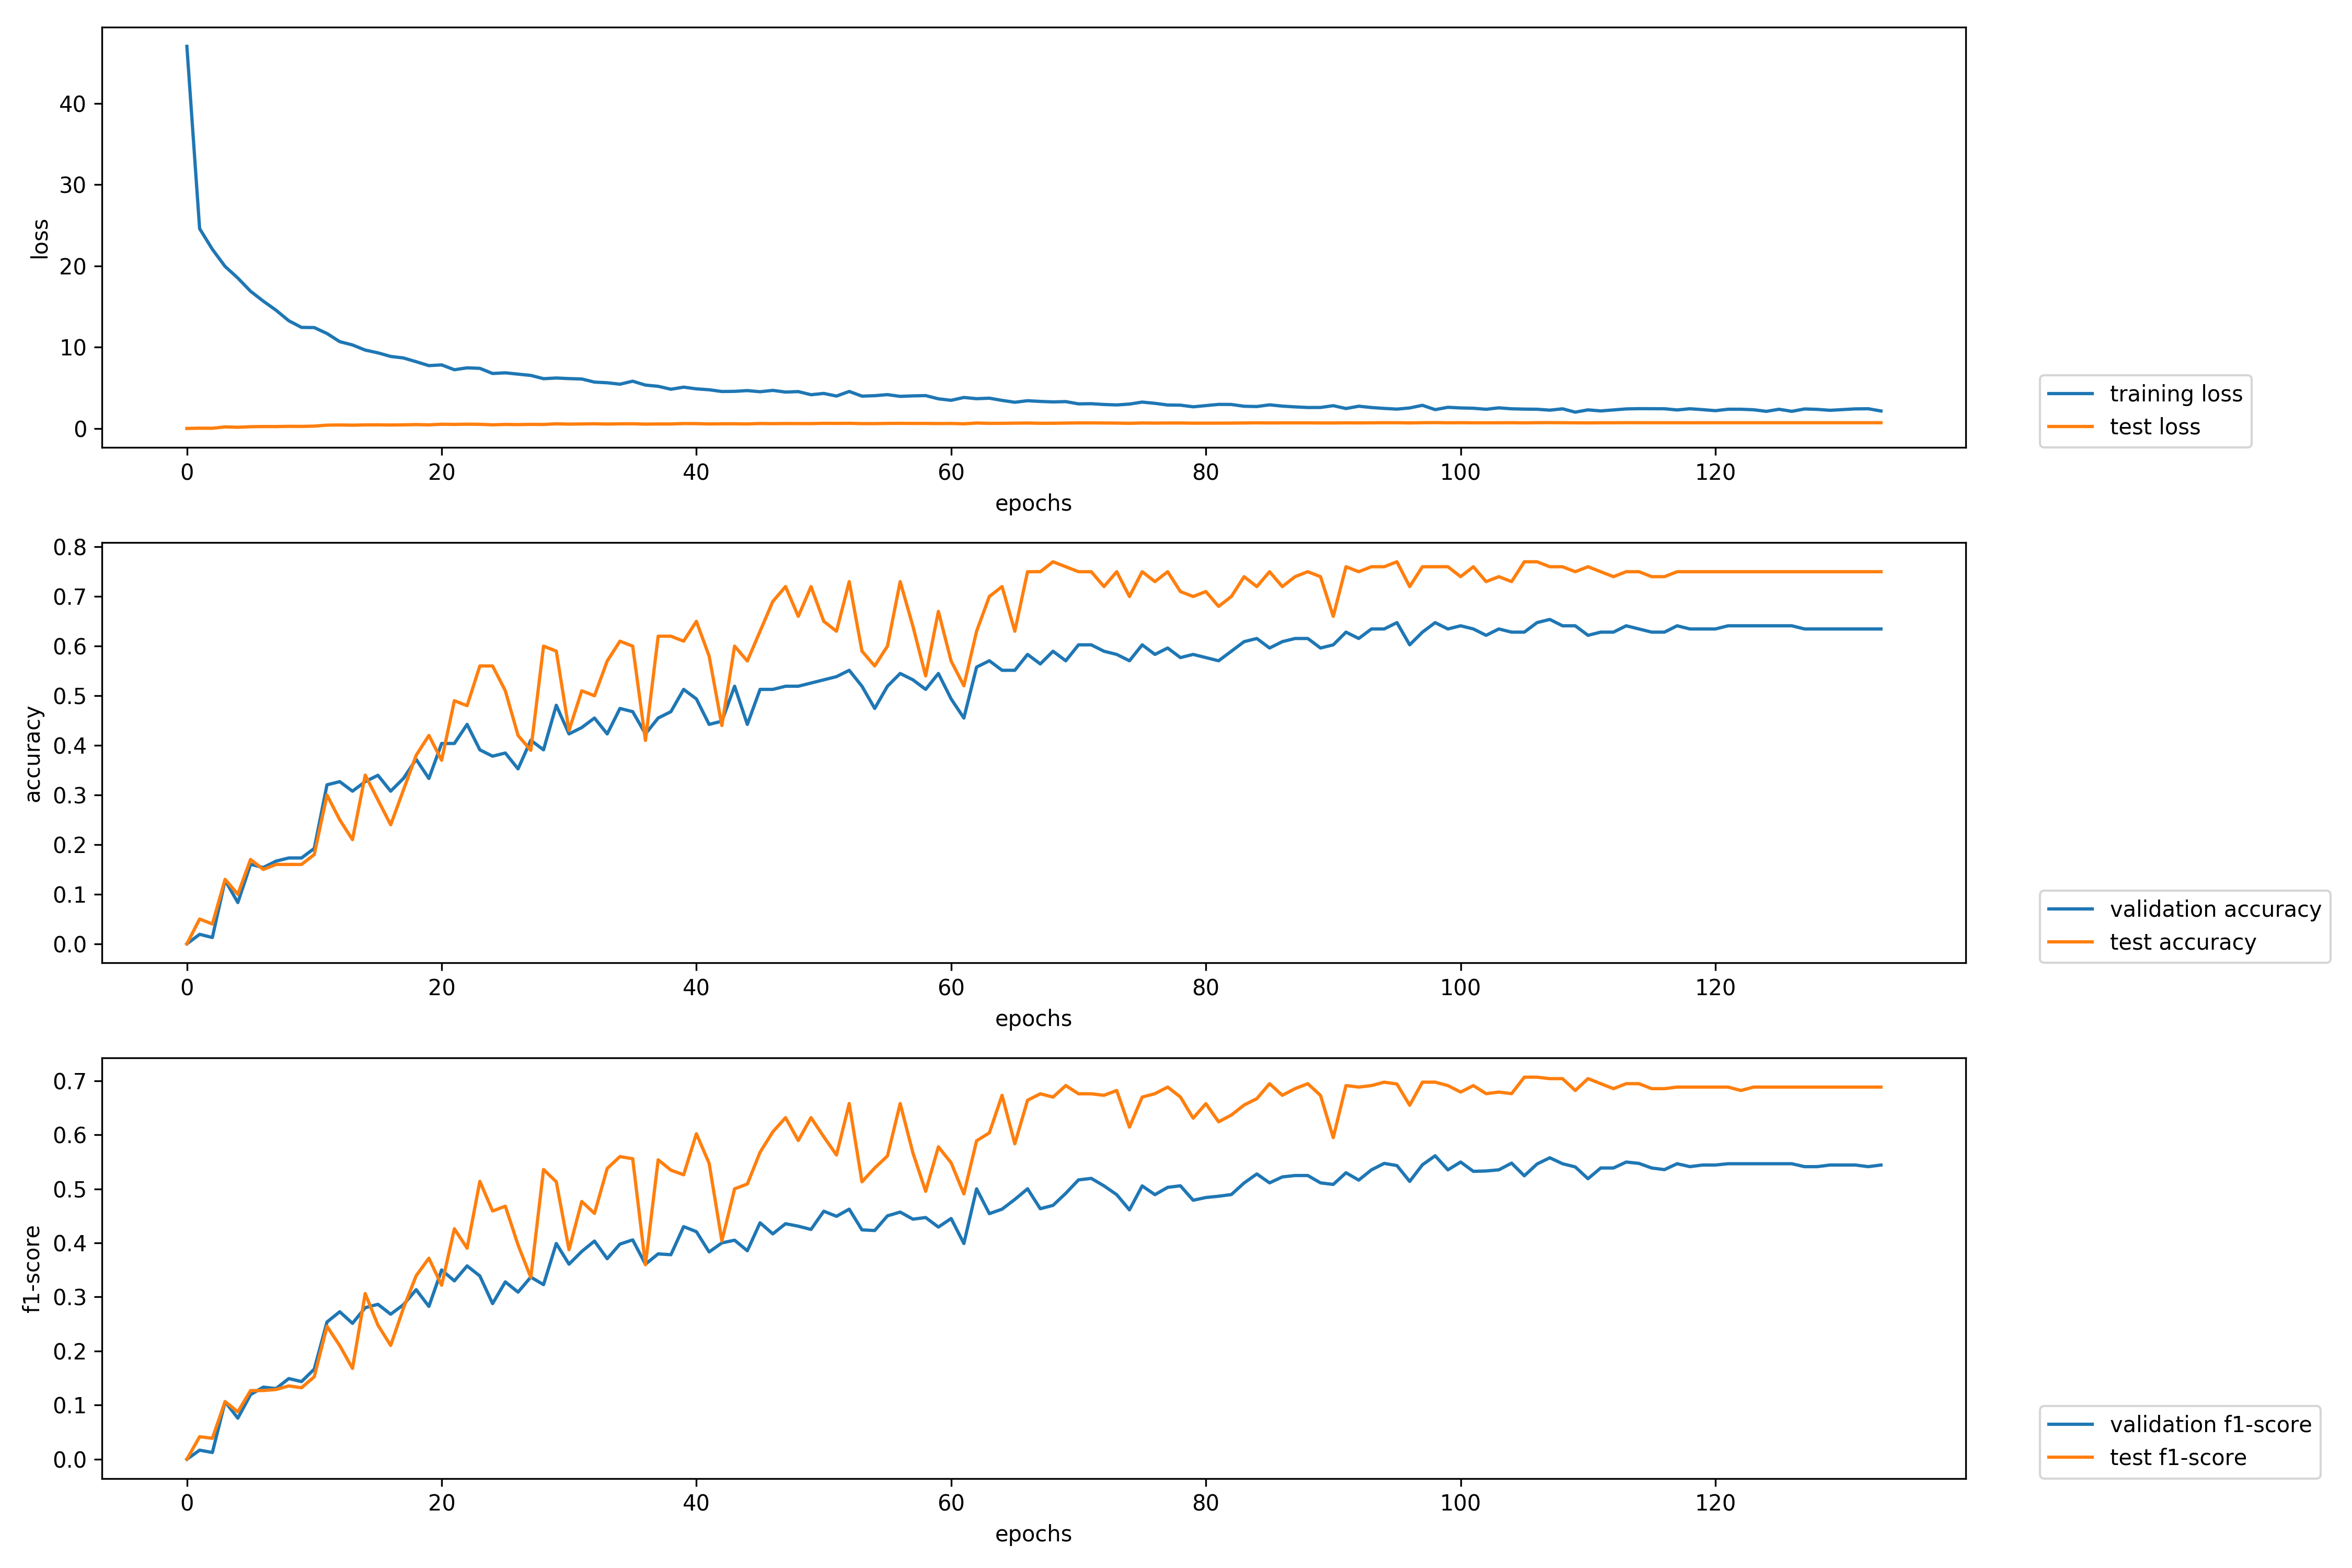

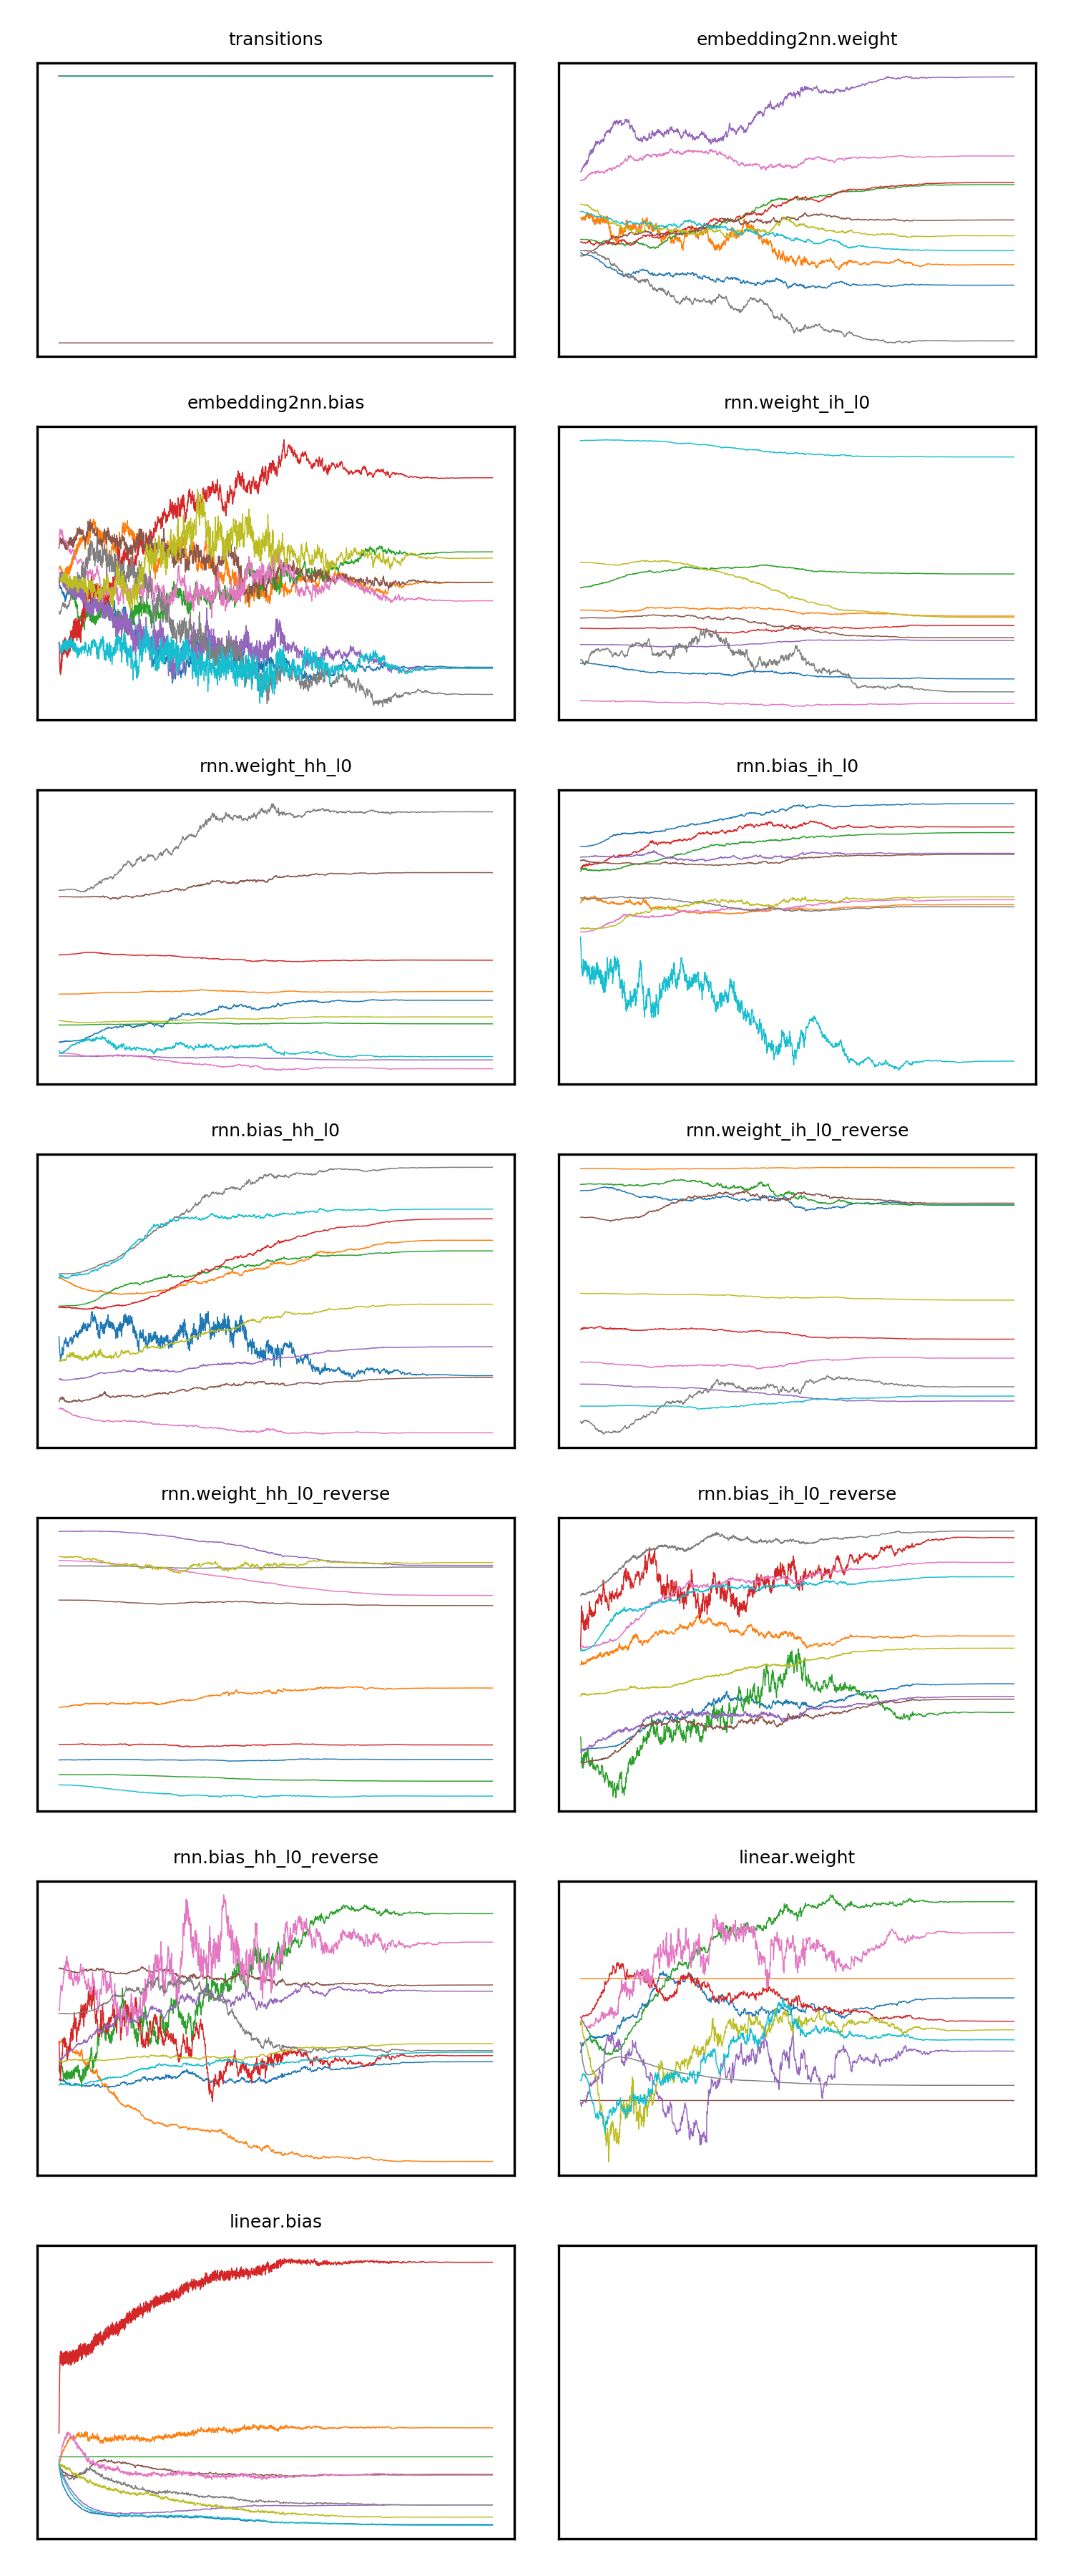

In [18]:
# 8. plot training curves (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('resources/taggers/example-ner/loss.tsv')
plotter.plot_weights('resources/taggers/example-ner/weights.txt')

from IPython.display import display, Image
display(Image(filename='resources/taggers/example-ner/training.png'))
display(Image(filename='resources/taggers/example-ner/weights.png'))

In [ ]:
from flair.embeddings import CharacterEmbeddings

# 4. initialize embeddings
embedding_types = [
    WordEmbeddings('ja-crawl'),
    CharacterEmbeddings(),
    FlairEmbeddings('japanese-forward'),
    FlairEmbeddings('japanese-backward')
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

# 5. initialize sequence tagger
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type=tag_type,
                        use_crf=True)

# 6. initialize trainer
trainer = ModelTrainer(tagger, corpus)

# 7. start training
trainer.train('resources/taggers/example-ner-full',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

2019-03-02 20:02:09,003 ----------------------------------------------------------------------------------------------------
2019-03-02 20:02:09,010 Evaluation method: MICRO_F1_SCORE
2019-03-02 20:02:09,016 ----------------------------------------------------------------------------------------------------
2019-03-02 20:02:33,142 epoch 1 - iter 0/13 - loss 86.22476959
2019-03-02 20:03:03,466 epoch 1 - iter 1/13 - loss 72.46079636
2019-03-02 20:03:28,028 epoch 1 - iter 2/13 - loss 59.13235219
2019-03-02 20:03:58,077 epoch 1 - iter 3/13 - loss 51.17839766
2019-03-02 20:04:29,977 epoch 1 - iter 4/13 - loss 46.39675064
2019-03-02 20:05:06,516 epoch 1 - iter 5/13 - loss 42.83161799
2019-03-02 20:05:28,953 epoch 1 - iter 6/13 - loss 40.11553301
2019-03-02 20:05:52,120 epoch 1 - iter 7/13 - loss 37.77716756
2019-03-02 20:06:10,560 epoch 1 - iter 8/13 - loss 36.12758848
2019-03-02 20:06:33,447 epoch 1 - iter 9/13 - loss 34.69828205
2019-03-02 20:07:00,046 epoch 1 - iter 10/13 - loss 33.5630949

In [15]:
from flair.embeddings import BertEmbeddings
embeddings = BertEmbeddings('bert-base-multilingual-cased')

100%|██████████| 662804195/662804195 [03:25<00:00, 3231063.78B/s]


In [16]:
sentence = Sentence('犬 が 歩い た 。')
embeddings.embed(sentence)
for token in sentence:
    print(token)
    print(token.embedding)

Token: 1 犬
tensor([-0.3516, -0.6004,  0.8889,  ...,  2.1274,  0.4084, -0.4221])
Token: 2 が
tensor([-0.3026, -0.1525,  0.6352,  ...,  1.2978,  1.2199,  0.1203])
Token: 3 歩い
tensor([-0.3477, -0.2779, -0.2833,  ...,  0.3886,  1.3384, -0.3602])
Token: 4 た
tensor([-0.2483, -0.4698,  0.1580,  ...,  0.6561,  1.2581, -0.0734])
Token: 5 。
tensor([ 0.0618, -0.7438,  0.1669,  ...,  0.3078,  0.6511, -0.2206])


In [17]:
from flair.embeddings import FlairEmbeddings
ja_forward = FlairEmbeddings('japanese-forward')
ja_backward = FlairEmbeddings('japanese-backward')

2019-03-02 17:06:53,526 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/lm__char-forward__ja-wikipedia-3GB/japanese-forward.pt not found in cache, downloading to /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp5viq5oex


100%|██████████| 335383050/335383050 [02:00<00:00, 2789306.65B/s]

2019-03-02 17:08:54,819 copying /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp5viq5oex to cache at /Users/umemoto/.flair/embeddings/japanese-forward.pt


2019-03-02 17:08:56,604 removing temp file /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp5viq5oex
2019-03-02 17:08:59,733 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/lm__char-backward__ja-wikipedia-3GB/japanese-backward.pt not found in cache, downloading to /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmppx5dqf4p


100%|██████████| 335383032/335383032 [02:00<00:00, 2788974.42B/s]

2019-03-02 17:11:01,091 copying /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmppx5dqf4p to cache at /Users/umemoto/.flair/embeddings/japanese-backward.pt


2019-03-02 17:11:03,091 removing temp file /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmppx5dqf4p


In [19]:
glove = WordEmbeddings('glove')

2019-03-02 17:11:42,637 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp5t0wy6eo


100%|██████████| 160000128/160000128 [04:34<00:00, 582115.85B/s] 

2019-03-02 17:16:18,598 copying /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp5t0wy6eo to cache at /Users/umemoto/.flair/embeddings/glove.gensim.vectors.npy


2019-03-02 17:16:19,005 removing temp file /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp5t0wy6eo
2019-03-02 17:16:20,241 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp7bi0xdf_


100%|██████████| 21494764/21494764 [00:36<00:00, 590103.73B/s] 

2019-03-02 17:16:57,694 copying /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp7bi0xdf_ to cache at /Users/umemoto/.flair/embeddings/glove.gensim
2019-03-02 17:16:57,755 removing temp file /var/folders/zz/2zgmhj3d5254b42t1sksmhqr0000gn/T/tmp7bi0xdf_
